# Nonparametric Discovery of Human Routines from Sensor Data
This notebook tried to reproduce the result from the paper:
Nonparametric Discovery of Human Routines from Sensor Data
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.681.3152&rep=rep1&type=pdf  

Dataset: 
Discovery of Activity Patterns using Topic Models
Tam Huynh, Mario Fritz and Bernt Schiele. In Ubicomp'08  
http://datasets.d2.mpi-inf.mpg.de/ubicomp08/dataset_huynh_ubicomp08.zip


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

from sklearn.mixture import BayesianGaussianMixture # The library for DPGMM
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import AffinityPropagation # The library for AP
from sklearn.model_selection import GridSearchCV

import scipy as sp
from scipy.spatial.distance import jensenshannon

import tomotopy as tp  # The library for HDP

from itertools import chain
from statistics import mode
import itertools

import pickle

In [7]:
path = 'dataset_huynh_ubicomp08'
full = np.zeros(shape=(1,1))
for i in range(7):
    data = np.loadtxt(path+'/day'+str(i+1)+'-data.txt')
    activities = np.expand_dims( np.loadtxt(path+'/day'+str(i+1)+'-activities.txt') , axis=1)
    routines = np.expand_dims( np.loadtxt(path+'/day'+str(i+1)+'-routines.txt') , axis=1)
    data =  np.concatenate((data, activities, routines), axis=1)
    if i==0:
        total = data
    total = np.concatenate((total,data), axis=0 )

In [8]:
features = ['mean_px','mean_py','mean_pz','var_px','var_py','var_pz','mean_wx','mean_wy','mean_wz','var_wx','var_wy','var_wz','time','activities','routines']
total = pd.DataFrame(data=total,columns=features)
total['activities'] = total['activities'].astype(int)
total['routines'] = total['routines'].astype(int)
routines_label = [ 'unlabeled', 'dinner activities', 'commuting', 'lunch routine', 'office work']

In [9]:
activities_label = {}
with open(path+'/activities.txt') as fp:
    line = fp.readline()
    cnt = 0
    while line:
        print("Line {}: {}".format(cnt, line.strip()))
        if (line.strip() != ''):
            activities_label[cnt] = line.strip()
        line = fp.readline()
        cnt += 1

Line 0: unlabeled
Line 1: driving bike
Line 2: driving cart through supermarket
Line 3: driving car
Line 4: brushing teeth
Line 5: personal hygiene
Line 6: kneeling
Line 7: running
Line 8: sitting  having a coffee
Line 9: having breakfast
Line 10: having dinner
Line 11: having lunch
Line 12: sitting  talking on phone
Line 13: using the toilet
Line 14: sitting  desk activities
Line 15: standing  talking
Line 16: standing  having a coffee
Line 17: queuing in line
Line 18: standing  talking on phone
Line 19: standing  using the toilet
Line 20: walking
Line 21: walking while carrying something
Line 22: walking freely
Line 23: washing dishes
Line 24: picking up mensa food
Line 25: lying  using computer
Line 26: wiping the whiteboard
Line 27: discussing at whiteboard
Line 28: kneeling  making fire for barbecue
Line 29: fanning barbecue
Line 30: washing hands
Line 31: setting the table
Line 32: watching movie
Line 33: making coffee
Line 34: attending a presentation
Line 35: preparing food
Lin

Text(0.5, 1.0, 'dinner activities')

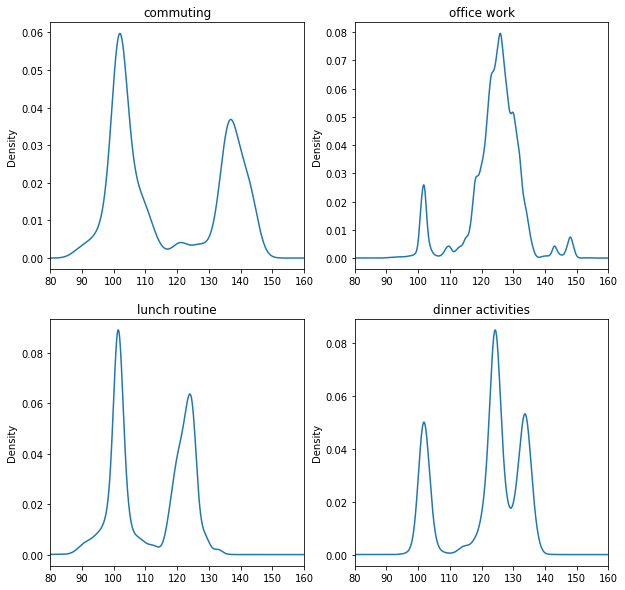

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(10,10) )
axs[0,0].set_xlim([80, 160])
#axs[0,0].legend('test', loc='upper right')
total[total.routines ==2]['mean_py'].plot(kind='kde', ax=axs[0, 0])
axs[0,0].set_title('commuting')

axs[0,1].set_xlim([80, 160])
total[total.routines ==4]['mean_py'].plot(kind='kde', ax=axs[0, 1])
axs[0,1].set_title( 'office work' )

axs[1,0].set_xlim([80, 160])
total[total.routines ==3]['mean_py'].plot(kind='kde', ax=axs[1, 0])
axs[1,0].set_title('lunch routine')

axs[1,1].set_xlim([80, 160])
total[total.routines ==1]['mean_py'].plot(kind='kde', ax=axs[1, 1])
axs[1,1].set_title('dinner activities')

Text(0.5, 1.0, 'dinner activities')

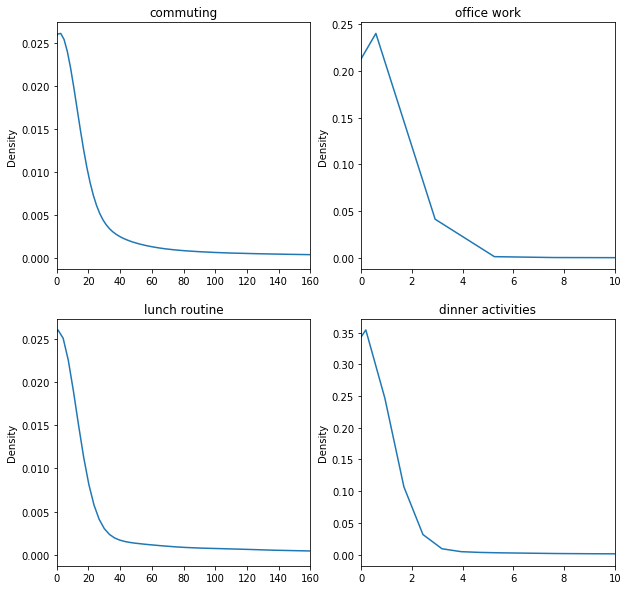

In [846]:
fig, axs = plt.subplots(2, 2, figsize=(10,10) )
axs[0,0].set_xlim([0, 160])
#axs[0,0].legend('test', loc='upper right')
total[total.routines ==2]['var_py'].plot(kind='kde', ax=axs[0, 0])
axs[0,0].set_title('commuting')

axs[0,1].set_xlim([0, 10])
total[total.routines ==4]['var_py'].plot(kind='kde', ax=axs[0, 1])
axs[0,1].set_title( 'office work' )

axs[1,0].set_xlim([0, 160])
total[total.routines ==3]['var_py'].plot(kind='kde', ax=axs[1, 0])
axs[1,0].set_title('lunch routine')

axs[1,1].set_xlim([0, 10])
total[total.routines ==1]['var_py'].plot(kind='kde', ax=axs[1, 1])
axs[1,1].set_title('dinner activities')

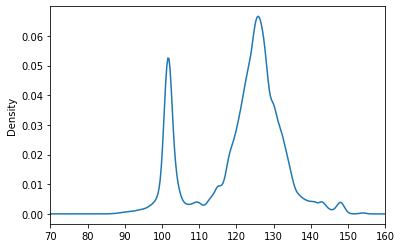

In [850]:
fig, ax = plt.subplots()
ax.set_xlim([70, 160])
total['mean_py'].plot(kind='kde', ax=ax)

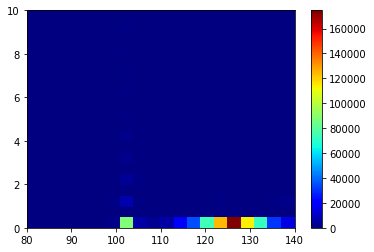

In [845]:
plt.hist2d(total['mean_py'], total['var_py'], range=[[80,140],[0,10]], bins=(20, 20), cmap=plt.cm.jet)
plt.colorbar()

# Dirichlet process Gaussian mixture model (DPGMM)
Library:  
sklearn.mixture.BayesianGaussianMixture

In [10]:
subspaces = [ ['mean_px','var_px'], ['mean_py','var_py'], ['mean_pz','var_pz'], ['mean_wx','var_wx'], ['mean_wy','var_wy'], ['mean_wz','var_wz'] ]

In [11]:
total[  list( chain.from_iterable(subspaces) ) ].describe()

,mean_px,var_px,mean_py,var_py,mean_pz,var_pz,mean_wx,var_wx,mean_wy,var_wy,mean_wz,var_wz
count,887661.000000,887661.000000,887661.000000,887661.000000,887661.000000,887661.000000,887661.000000,887661.000000,887661.000000,887661.000000,887661.000000,887661.000000
mean,143.706008,8.311775,121.358922,7.140563,107.682089,4.276267,120.292426,5.142271,113.347698,4.676724,98.261666,2.872498
std,10.679764,57.735157,11.550218,44.619971,8.763871,28.769430,10.853985,28.856353,7.726753,27.972884,8.906067,18.491441
min,7.000000,-0.389291,7.000000,-0.476128,7.000000,-1.813154,62.558221,-94.534730,82.062948,-88.604889,65.803783,-81.249267
25%,138.000000,0.000000,117.000000,0.000000,100.000000,0.000000,117.000000,0.000000,108.951820,0.000000,91.648596,0.000000
50%,148.000000,0.000000,124.000000,0.000000,108.000000,0.000000,121.009382,0.000000,113.972670,0.000000,95.000000,0.000000
75%,151.000000,0.000000,128.000000,0.000000,114.000000,0.000000,123.442031,0.227137,118.059578,1.118410,103.000000,0.595182
max,163.000000,1422.000000,155.000000,1621.000000,139.000000,1253.000000,155.061983,1644.596781,178.445634,1568.648643,143.629420,1593.851007


In [143]:
model_bay = [ None for _ in range(len(subspaces)) ]
score_bay = [ None for _ in range(len(subspaces)) ]
converge_bay = [None for _ in range(len(subspaces)) ]

In [263]:
parameters = [(6,0.1,2)]
for i_subspace, sub in enumerate(subspaces):
    print("subspace:", i_subspace )
    for i,para in enumerate( parameters ):
        n_com, weight, dof = para
        model_bay[i_subspace]= BayesianGaussianMixture( n_components=n_com, covariance_type= 'full',max_iter=2000, init_params= 'kmeans', weight_concentration_prior_type = 'dirichlet_process',
                                                   weight_concentration_prior= weight, degrees_of_freedom_prior=dof, warm_start= True, verbose=1) 
        model_bay[i_subspace].fit(  total[subspaces[i_subspace]]  )
        score_bay[i_subspace] = model_bay[ i_subspace  ].score(  total[subspaces[i_subspace]]  ) 
        converge_bay[i_subspace] = model_bay[ i_subspace  ].converged_
        print(  converge_bay[i_subspace] )
        print(  score_bay[i_subspace] )

subspace: 0
4 0.1 2
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
  Iteration 100
Initialization converged: True
True
-3.1639428952866195
subspace: 1
4 0.1 2
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
  Iteration 100
  Iteration 110
  Iteration 120
  Iteration 130
  Iteration 140
  Iteration 150
Initialization converged: True
True
-2.77257142840521
subspace: 2
4 0.1 2
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
Initialization converged: True
True
-2.1700049069355023
subspace: 3
4 0.1 2
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
  Iteration 100
  Iteration 110
  Iteration 120
Initialization c

In [ ]:
#####################

In [264]:
###
dirichlet =  model_bay

In [265]:
# Save the model
#pickle.dump(dirichlet, open('pkl_objects/model_cluster4_alpha01.pkl','wb'))

In [297]:
#load the model
dirichlet = pickle.load(open('pkl_objects/model_cluster6_alpha01.pkl', 'rb'))

In [298]:
label = []
for index_sub, sub in enumerate(subspaces[:]):
    label.append( dirichlet[index_sub].predict(total[sub]) )

In [299]:
# create the features for the artificial words
words_features = []
for i, sub in enumerate(subspaces[:]):
    total['w'+str(i+1)] = label[i]
    words_features.append('w'+str(i+1))

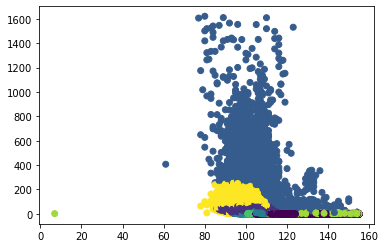

In [1662]:
plt.scatter(total[subspaces[1][0]], total[subspaces[1][1]], c=label[1] )
plt.show()

# Document creation  
Ref:  
T. Huynh, M. Fritz, and B. Schiele, “Discovery of activity patterns using topic models,” in Proceedings of the 10th international conference on Ubiquitous computing, New York, NY, USA, 2008, pp. 10–19.  
http://mobvis.org/publications/ubicomp2008.pdf

In [150]:
## Translate the Matlab serial date number to the day (with first day =0) and hour

In [300]:
total['day'] =  (total['time']/(60*60*24)).astype(np.int32)
total['hour'] = ( total['time']/ (60*60*24) - total['day'] ) * 24

In [301]:
day_min = total['day'].min()
day_max = total['day'].max()

In [302]:
print(day_min,day_max)

13733 13741


In [303]:
total['day'] = total['day'] - day_min
days = total['day'].value_counts().index.tolist()

In [304]:
days

[8, 7, 6, 0, 5, 1, 2]

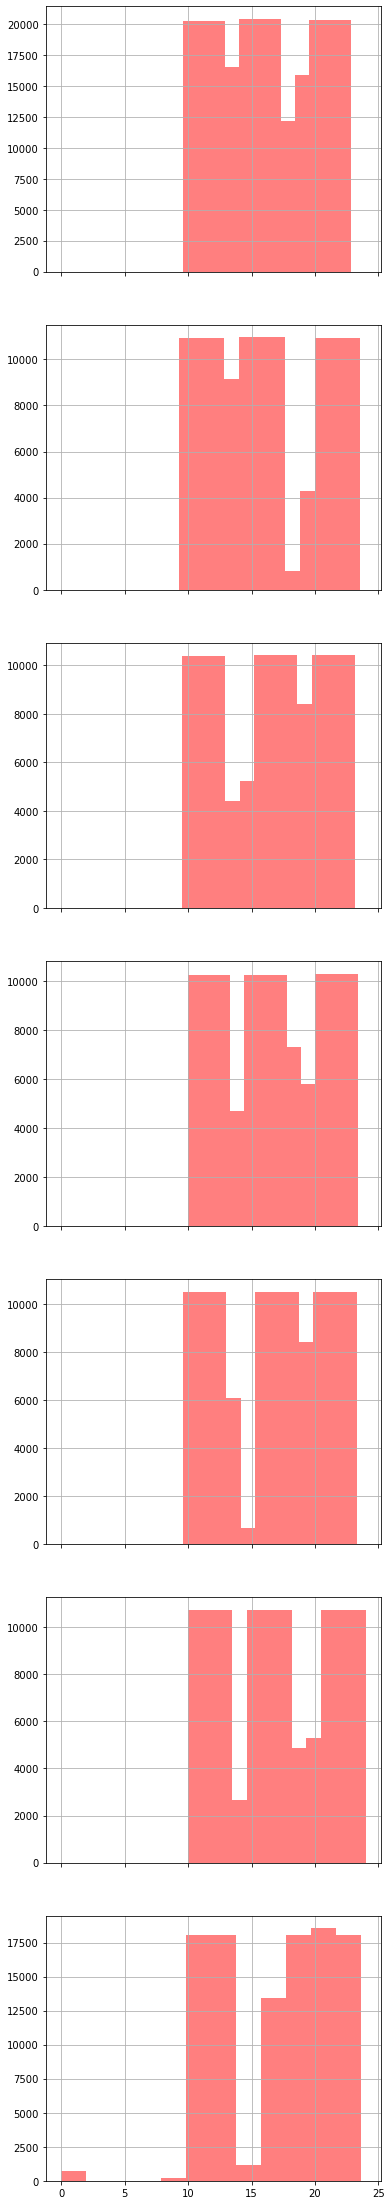

In [305]:
# Check the histogram of the sensor data collection everyday
fig, ax = plt.subplots(7, 1, sharex='col', sharey='row', figsize=(6, 40))
n = 3
for i,day in enumerate(days):
    total[total.day==day]['hour'].hist(bins=12, ax=ax[i], alpha=0.5, color='red')
#    df.hist(column=df.columns[j+n], bins=12, ax=ax[j], alpha=0.5, color='blue')
#    ax[j].set_title(df.columns[j][2:])

### Create the label (the time in the unit of hour) for the documents

In [306]:
time_interval = []
for day in days:
#    t0 = total[ total.day == day ].head(1)['time']
#    t1 = total[ total.day == day ].tail(1)['time']
#    n_interval = (t1 - t0)/ ( 27.5 * 60 )
    t0 = total[ (total.day == day) & (total.hour > 3) ]['hour'].min()  # The hour before 3 might be the data from previous day
    t1 = total[ total.day == day ]['hour'].max() 
    n_interval = int ( (t1 - t0) * 60 /  27.5 ) + 1
    interval = []
    for i in range(n_interval):
        interval.append( t0 + i * 27.5/60 )
    time_interval.append( interval )

In [307]:
time_interval

[[9.578333331402973,
  10.036666664736307,
  10.49499999806964,
  10.953333331402973,
  11.411666664736307,
  11.86999999806964,
  12.328333331402973,
  12.786666664736307,
  13.24499999806964,
  13.703333331402973,
  14.161666664736305,
  14.619999998069641,
  15.078333331402973,
  15.536666664736305,
  15.994999998069641,
  16.453333331402973,
  16.911666664736305,
  17.36999999806964,
  17.828333331402973,
  18.28666666473631,
  18.744999998069638,
  19.203333331402973,
  19.66166666473631,
  20.119999998069638,
  20.578333331402973,
  21.03666666473631,
  21.494999998069638,
  21.953333331402973,
  22.41166666473631],
 [9.282222222493147,
  9.74055555582648,
  10.198888889159813,
  10.657222222493147,
  11.11555555582648,
  11.573888889159813,
  12.032222222493147,
  12.49055555582648,
  12.948888889159813,
  13.407222222493147,
  13.865555555826479,
  14.323888889159814,
  14.782222222493147,
  15.240555555826479,
  15.698888889159814,
  16.157222222493147,
  16.61555555582648,
  

## Create the documents

In [308]:
# Then we will construct documents from sliding windows
# Bacause the sliding windows have overlap with 2.5 mins,
# each data points might belong to one or two sliding windows.
# The time of the data point t lies between [ tb_n , te_n ] => tb_n < t < te_n
# The overlap means sometimes tb_{n+1} < t < te_n 
# We can know whether the data point belongs to two sliding windows by:
# calculating the index (nb) of the beginning time of the sliding windows which is closest to the time of the data point
# and the index (ne) of the ending time of sliding windows which is closest to the time of the data point
documents_all = []
routines_all = []
activities_all = []

for i,day in enumerate(days):
    df = total[ (total.day == day) & (total.hour > 3) ] #
    t0 = df['time'].min()
    documents = [ [] for _ in range( len(time_interval[i]) )]
    routines = [ [] for _ in range( len(time_interval[i]) )]
    activities = [ [] for _ in range( len(time_interval[i]) )]
    for index, row in df.iterrows():
        word = row[ words_features ].astype(int).tolist()
        deltat = ( row['time'] - t0 )/60  # devided by 60 because we want to use the unit minute 
        nb = int( deltat /  27.5 )    # 0,1,2,.....
        ne = int( ( deltat - 30 ) / 27.5 ) + 1
        ne = ne if ne >= 0 else 0     # 0,1,2...
        documents[ne].append( word )
        routines[ne].append( row[ 'routines' ] )
        activities[ne].append( row[ 'activities' ] )
        if (nb == ne+1): 
            documents[nb].append( word )
            routines[nb].append( row[ 'routines' ] )
            activities[nb].append( row[ 'activities' ] )
    documents_all = documents_all + documents
    routines_all = routines_all + routines
    activities_all = activities_all + activities

In [309]:
# TO make sure that there is no empty 
i_doc = -1
i_doc_empty = []
i_empty_time = []
for i in range(len(time_interval) ):
    for j in range( len(time_interval[i]) ):
        i_doc += 1
        if( documents_all[ i_doc ] == [] ):
            i_doc_empty.append( i_doc )
            i_empty_time.append( (i,j) )

for i in reversed(i_doc_empty):
    documents_all.pop(i)
    routines_all.pop(i)
    activities_all.pop(i)
for i,j in reversed(i_empty_time):
    time_interval[i].pop(j)

# hierarchical Dirichlet process  
Library:  
https://bab2min.github.io/tomotopy/v0.9.0/en/  
Ref:  
T. Huynh, M. Fritz, and B. Schiele, “Discovery of activity patterns using topic models,” in Proceedings of the 10th international conference on Ubiquitous computing, New York, NY, USA, 2008, pp. 10–19.  
http://mobvis.org/publications/ubicomp2008.pdf

In [338]:
min_cf = 150
mdl = tp.HDPModel(tw=tp.TermWeight.ONE, min_cf=min_cf, rm_top=0)

doc_list = []
for doc in documents_all:
    doc_as_wordlist = []
    for a_word in doc:
        word = ''.join([chr( integer + 97 ) for integer in a_word])
        doc_as_wordlist.append( word )
    doc_list.append( doc_as_wordlist )
    mdl.add_doc(doc_as_wordlist)

In [339]:
mdl.burn_in = 2000
mdl.train(0)

vocabs_set = set()
for i, word in enumerate( mdl.vocabs ):
    if mdl.vocab_freq[i] >= min_cf:
        vocabs_set.add(  word )

doc_list_AfterRemove = []
for doc in doc_list:
    doc_as_wordlist = []
    for word in doc:
        if word in vocabs_set:
            doc_as_wordlist.append(word)
    doc_list_AfterRemove.append(doc_as_wordlist)

#del doc_list

print('Num docs:', len(mdl.docs), ', Vocab size:', len(mdl.used_vocabs), ', Num words:', mdl.num_words)
print('Removed top words:', mdl.removed_top_words)

doc_tp = []
for i,doc in enumerate(doc_list_AfterRemove):
    doc_tp.append( mdl.make_doc(doc) )

Num docs: 199 , Vocab size: 216 , Num words: 858912
Removed top words: []


In [340]:
distr = []
mdl.train(mdl.burn_in)
for i in range(0, 3000, 20):
    mdl.train(20)
    print('Iteration: {}\tLog-likelihood: {}\tNum. of topics: {}'.format(i, mdl.ll_per_word, mdl.live_k))
    distr1 = []
    for doc in doc_tp:
        distr2, ll = mdl.infer(doc)
        distr1.append( distr2 )
    distr1 = np.array( distr1 )
    distr.append(distr1)

Iteration: 0	Log-likelihood: -2.146782470002543	Num. of topics: 5
Iteration: 20	Log-likelihood: -2.147110756021357	Num. of topics: 6
Iteration: 40	Log-likelihood: -2.1470776277418593	Num. of topics: 6
Iteration: 60	Log-likelihood: -2.1467290882107655	Num. of topics: 7
Iteration: 80	Log-likelihood: -2.1461716841599996	Num. of topics: 7
Iteration: 100	Log-likelihood: -2.145709249906766	Num. of topics: 7
Iteration: 120	Log-likelihood: -2.1463565341650144	Num. of topics: 6
Iteration: 140	Log-likelihood: -2.1452943127448836	Num. of topics: 6
Iteration: 160	Log-likelihood: -2.14682987877942	Num. of topics: 5
Iteration: 180	Log-likelihood: -2.146714379536748	Num. of topics: 5
Iteration: 200	Log-likelihood: -2.146711616523312	Num. of topics: 5
Iteration: 220	Log-likelihood: -2.145331488593616	Num. of topics: 5
Iteration: 240	Log-likelihood: -2.145831509835689	Num. of topics: 5
Iteration: 260	Log-likelihood: -2.1470335417518274	Num. of topics: 6
Iteration: 280	Log-likelihood: -2.146848518432716

Iteration: 2380	Log-likelihood: -2.1466646624926744	Num. of topics: 7
Iteration: 2400	Log-likelihood: -2.148599777951046	Num. of topics: 6
Iteration: 2420	Log-likelihood: -2.148416087147949	Num. of topics: 7
Iteration: 2440	Log-likelihood: -2.1490102607721737	Num. of topics: 7
Iteration: 2460	Log-likelihood: -2.1493640247318666	Num. of topics: 7
Iteration: 2480	Log-likelihood: -2.151129332657625	Num. of topics: 7
Iteration: 2500	Log-likelihood: -2.150851722472067	Num. of topics: 7
Iteration: 2520	Log-likelihood: -2.1497550514906223	Num. of topics: 7
Iteration: 2540	Log-likelihood: -2.149995656404169	Num. of topics: 7
Iteration: 2560	Log-likelihood: -2.1508374763929226	Num. of topics: 7
Iteration: 2580	Log-likelihood: -2.1508879420663227	Num. of topics: 7
Iteration: 2600	Log-likelihood: -2.148965757796399	Num. of topics: 7
Iteration: 2620	Log-likelihood: -2.1514810599068306	Num. of topics: 8
Iteration: 2640	Log-likelihood: -2.1507792462618784	Num. of topics: 7
Iteration: 2660	Log-likeli

In [341]:
max_size = max( [ item.shape[1]  for item in distr ] )
for i, item in enumerate(distr):
    size_diff = max_size - item.shape[1]
    if size_diff>0:
        distr[i] = np.c_[ item , np.zeros((item.shape[0], size_diff), dtype=item.dtype) ]

distr = np.array(distr)
distr = np.mean( distr, axis=0)

# Affinity Propagation (AP) clustering with the usage of Jensen-Shannon divergence metric  
Library:  
scipy.spatial.distance.jensenshannon  + sklearn.cluster.AffinityPropagation  

Ref:  
B. J. Frey and D. Dueck, “Clustering by passing messages between data points,” Science, vol. 315, p. 2007, 2007. 
http://utstat.toronto.edu/reid/sta414/frey-affinity.pdf

### calculating the similarity between two topic proportions the usage of Jensen-Shannon divergence

In [342]:
js_similarity = np.zeros(shape=(distr.shape[0],distr.shape[0]))
for j in range(distr.shape[0]):
    for i in range( j+1 ):
        js_similarity[i][j] = math.exp( - (jensenshannon( distr[i], distr[j] ) )**2   ) 
#        js_similarity[i][j] = math.exp( - (jensenshannon( distr[i], distr[j] ) ) ) 
#        js_similarity[i][j] = np.sum ( np.square( distr_act[i]- distr_act[j] ) )
        js_similarity[j][i] = js_similarity[i][j]

### Affinity Propagation (AP) clustering

In [343]:
clustering = AffinityPropagation( affinity = 'precomputed', max_iter=5000, convergence_iter=15  )
clustering_label = clustering.fit_predict( -js_similarity  )
# negative sign here is needed because of the definition of the similarity in scikit-learn library

/Users/jay/anaconda3/envs/tf2/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(("'random_state' has been introduced in 0.23. "


 # Qualitative analysis

In [402]:
# To get the most dominated ground-truth routine in each time window.
routines_dominated=[]
for i in  range(len(routines_all)):
    routine = mode( routines_all[i] )
    routines_dominated.append( routine )

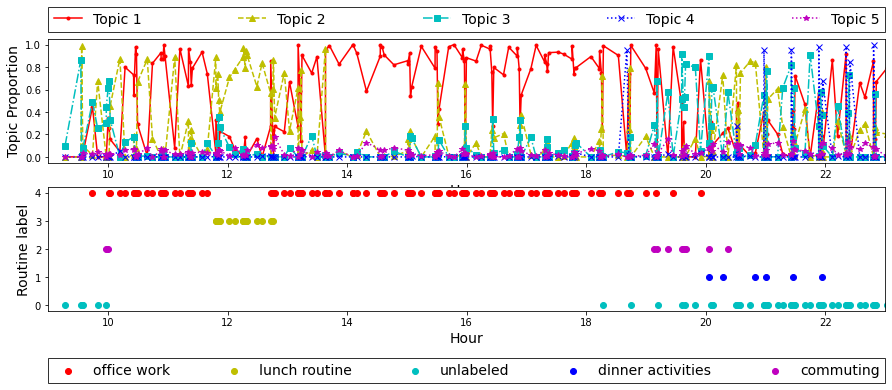

In [403]:
# The comparison between the topic proportions inferred from HDP and the ground-truth routines
fig, ax = plt.subplots( 2, figsize=(15,5) )

topic_range = min( len( distr[0] ), 10 )
topic_top = (-np.sum(distr, axis=0)).argsort()[:topic_range]


topic_top_reorder = []
list_time = list( chain.from_iterable(time_interval) )
time_reorder = []
for i in range(topic_range):
    lists = sorted(zip(*[ list_time , np.array(distr).T[ topic_top[i] ]]  ))
    time_reorder, topic_top_new = list(zip(*lists))
    topic_top_reorder.append( topic_top_new )

    

ax[0].set_xlim([9, 23])

ax[0].plot( time_reorder , topic_top_reorder[0], 'r.-' , label="Topic {}".format(1))
ax[0].plot( time_reorder , topic_top_reorder[1], 'y^--', label="Topic {}".format(2) )
ax[0].plot( time_reorder , topic_top_reorder[2], 'cs-.', label="Topic {}".format(3) )
ax[0].plot( time_reorder , topic_top_reorder[3], 'bx:', label="Topic {}".format(4) )
ax[0].plot( time_reorder , topic_top_reorder[4], 'm*:', label="Topic {}".format(5) )
ax[0].set_xlabel('Hour', fontsize=14)
ax[0].set_ylabel('Topic Proportion', fontsize=14)

s = fig.subplotpars
bb=[s.left, s.top+0.02, s.right-s.left, 5 ]
leg = ax[0].legend( loc= 8,bbox_to_anchor=bb, mode="expand", borderaxespad=0, ncol= 5,
                bbox_transform=fig.transFigure, fancybox=False, edgecolor="k", prop={'size':14})


ax[1].set_xlim([9, 23])
color_dict = {4:'r', 3:'y', 0:'c', 1:'b', 2:'m'}
colors = [ color_dict[int(i)]  for i in range(5)]

time_plot = [ [] for _ in range(5) ]
for time_int, routines_dom in zip( list( chain.from_iterable(time_interval) ), routines_dominated  ):
    time_plot[ int(routines_dom) ].append( time_int )
    
for i in color_dict:
    ax[1].scatter( time_plot[i], [i for _ in range(len(time_plot[i]))], c = colors[i], label = routines_label[i]  )
s = fig.subplotpars
bb=[s.left, s.bottom -0.2 , s.right-s.left, 5 ]
ax[1].legend(loc= 8,bbox_to_anchor=bb, mode="expand", borderaxespad=0, ncol= 5,
                bbox_transform=fig.transFigure, fancybox=False, edgecolor="k", prop={'size':14})
ax[1].set_xlabel('Hour', fontsize=14)
ax[1].set_ylabel('Routine label', fontsize=14)
plt.show()

The plot of the topic proportion here shows more oscillation than the plot in the paper. However, these inferred topics still reveal high correlation with annotated routine labels.

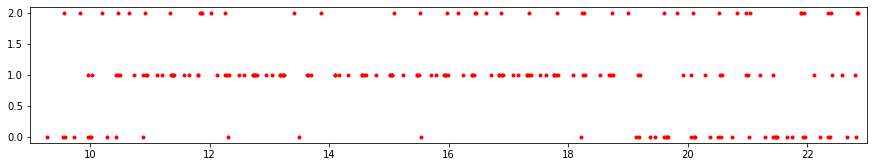

In [404]:
# check the discovered routines inferred from AP
fig, ax = plt.subplots( figsize=(15,2.5) )
ax.set_xlim([9, 23])
plt.plot( list( chain.from_iterable(time_interval) ) , clustering_label, 'r.' )

In [401]:
# The clustering from AP does not work well. Label 1 is 'office work'. 
# Other does not show any obvious corresponding routine labels.
clustering_label_to_routine = { 1: 'office work', 0:'commuting', 2: 'lunch routines' }

### Performance
Evaluation Measure:  
cluster purity: the percentage of documents whose ground-truth label is the same as its cluster label.  
Rand index: the percentage of document pairs that are correctly classified. (TP+TN)/(TP+TN+FP+FN)   
F measure: calculated from the precision and recall. 2*TP/( 2*TP+FP+FN )  

The documents with unlabeled ground-truth routines should not be included.

In [405]:
cluster_purity = 0.0
n_unlabeled = 0
for i,item in enumerate( routines_dominanting ):
    if (routines_label[int(item)] ==  clustering_label_to_routine[ clustering_label[i] ] ):
        cluster_purity += 1
    if (int(item) == 0 ):
        n_unlabeled += 1
cluster_purity = cluster_purity/( len( routines_dominanting ) - n_unlabeled )
print('culster purity:', cluster_purity)

culster purity: 0.6338028169014085


In [406]:
TP = 0
TN = 0
FP = 0
FN = 0
for i, item in enumerate( routines_dominanting ):
    for j in range(i+1):
        if( item !=0 and routines_dominanting[j] !=0 ):
            pair_ground_truth = (item == routines_dominanting[j])
            pair_discovered = (clustering_label[i] == clustering_label[j])
            if ( pair_ground_truth == True and pair_discovered == True ):
                TP += 1
            elif ( pair_ground_truth == False and pair_discovered == False ):
                TN += 1
            elif ( pair_ground_truth == False and pair_discovered == True ):   
                FP += 1
            else:
                FN += 1
Rand_index = (TP+TN)/(TP+TN+FP+FN)
F_measure = 2*TP/( 2*TP+FP+FN )
print( "Rand index:", Rand_index)
print( "F measure:", F_measure)

Rand index: 0.6039594208608293
F measure: 0.6449448123620309


My performance measure of the alignment between discovered routines and ground-truth routines:  
culster purity: 0.6338028169014085  
Rand index: 0.6039594208608293  
F measure: 0.6449448123620309  
Compared with the results in the paper, only the rand index is comparable. The other two quantitites from my evaluation are worse than the resuults in the paper.

# Conclusion

1. The topic proportion inferred from DPGMM + HDP reveal high correlation with annotated routine labels. But the plot shows some oscillation pattern which is not shown in the paper.
2. The discovered routines inferred from AP doesn't work very well. It only infers three main routines. The clustering evaluation metrics shows lower values here than in the paper. 

# Curious: how everything looks like if using the existing activitiy annotation

I tried to used the existing annotated activities as the artificial words and do the similar inference.

In [1894]:
count_act = CountVectorizer(min_df=3)
def activity_to_bow( activities , count ):
    act_list = []
    for act in activities:
        string=""
        for single_act in act:
            word = activities_label[single_act].replace(" ", "")
            string = string + word + " "
        act_list.append( string )

    bag = count.fit_transform( act_list )
    return bag, count

bag_act, count_act = activity_to_bow( activities_all , count_act )
id2token_act = {v: k for k, v in count_act.vocabulary_.items()}

bag_act_list = [ [] for _ in range( bag_act.shape[0] )]
for i, j in zip(*bag_act.nonzero()):
    bag_act_list[i].append( (j, bag_act[i,j] ) )

In [1924]:
model_hdp_act = HdpTransformer(id2word=id2token_act, kappa=1, alpha=0.1, gamma=0.1, K=15, T=35, tau=64)
model_hdp_act.fit( bag_act )
distr_act = model_hdp_act.transform( bag_act_list )
distr_act.shape

(199, 35)

In [249]:
min_cf = 3
mdl = tp.HDPModel(tw=tp.TermWeight.ONE, min_cf=min_cf, rm_top=0)

doc_act_list = []
for act in activities_all:
    doc_as_wordlist = []
    for single_act in act:
        word = activities_label[single_act].replace(" ", "")
        doc_as_wordlist.append( word )
    doc_act_list.append( doc_as_wordlist )
    mdl.add_doc(doc_as_wordlist)
    
    
mdl.burn_in = 2000
mdl.train(0)

vocabs_set = set()
for i, word in enumerate( mdl.vocabs ):
    if mdl.vocab_freq[i] >= min_cf:
        vocabs_set.add(  word )

doc_list_AfterRemove = []
for doc in doc_act_list:
    doc_as_wordlist = []
    for word in doc:
        if word in vocabs_set:
            doc_as_wordlist.append(word)
    doc_list_AfterRemove.append(doc_as_wordlist)

#del doc_list

print('Num docs:', len(mdl.docs), ', Vocab size:', len(mdl.used_vocabs), ', Num words:', mdl.num_words)
print('Removed top words:', mdl.removed_top_words)

doc_tp = []
for i,doc in enumerate(doc_list_AfterRemove):
    doc_tp.append( mdl.make_doc(doc) )
    
    
distr_act = []
mdl.train(mdl.burn_in)
for i in range(0, 2000, 10):
    mdl.train(10)
    print('Iteration: {}\tLog-likelihood: {}\tNum. of topics: {}'.format(i, mdl.ll_per_word, mdl.live_k))
#    if (i%20 == 0):
    distr1 = []
    for doc in doc_tp:
        distr2, ll = mdl.infer(doc)
        distr1.append( distr2 )
    distr1 = np.array( distr1 )
    distr_act.append(distr1)

Num docs: 199 , Vocab size: 35 , Num words: 962748
Removed top words: []
Iteration: 0	Log-likelihood: -0.9472676599867269	Num. of topics: 9
Iteration: 10	Log-likelihood: -0.9471682754317924	Num. of topics: 9
Iteration: 20	Log-likelihood: -0.9464572119118584	Num. of topics: 9
Iteration: 30	Log-likelihood: -0.9475707836764923	Num. of topics: 9
Iteration: 40	Log-likelihood: -0.9467319832149002	Num. of topics: 9
Iteration: 50	Log-likelihood: -0.9471378765008055	Num. of topics: 9
Iteration: 60	Log-likelihood: -0.9478052686496783	Num. of topics: 9
Iteration: 70	Log-likelihood: -0.9487359559785555	Num. of topics: 9
Iteration: 80	Log-likelihood: -0.9485570653202159	Num. of topics: 9
Iteration: 90	Log-likelihood: -0.9497253966538413	Num. of topics: 9
Iteration: 100	Log-likelihood: -0.9487001474924929	Num. of topics: 9
Iteration: 110	Log-likelihood: -0.9493555719394297	Num. of topics: 9
Iteration: 120	Log-likelihood: -0.9490861675571058	Num. of topics: 9
Iteration: 130	Log-likelihood: -0.9498540

Iteration: 1180	Log-likelihood: -0.9419164488833426	Num. of topics: 9
Iteration: 1190	Log-likelihood: -0.9424343088363449	Num. of topics: 9
Iteration: 1200	Log-likelihood: -0.9429751268362306	Num. of topics: 9
Iteration: 1210	Log-likelihood: -0.9427227549590421	Num. of topics: 9
Iteration: 1220	Log-likelihood: -0.9429128369619288	Num. of topics: 9
Iteration: 1230	Log-likelihood: -0.9423985780747768	Num. of topics: 9
Iteration: 1240	Log-likelihood: -0.9425868563273501	Num. of topics: 9
Iteration: 1250	Log-likelihood: -0.9418741021253209	Num. of topics: 9
Iteration: 1260	Log-likelihood: -0.9425105880418981	Num. of topics: 9
Iteration: 1270	Log-likelihood: -0.9413230259532691	Num. of topics: 10
Iteration: 1280	Log-likelihood: -0.9418529058313334	Num. of topics: 10
Iteration: 1290	Log-likelihood: -0.9417042393883037	Num. of topics: 10
Iteration: 1300	Log-likelihood: -0.9419432345019976	Num. of topics: 10
Iteration: 1310	Log-likelihood: -0.9419046956815562	Num. of topics: 10
Iteration: 1320

In [250]:
max_size = max( [ item.shape[1]  for item in distr_act ] )
for i, item in enumerate(distr_act):
    size_diff = max_size - item.shape[1]
    if size_diff>0:
        distr_act[i] = np.c_[ item , np.zeros((item.shape[0], size_diff), dtype=item.dtype) ]

distr_act = np.array(distr_act)
distr_act = np.mean( distr_act, axis=0)

In [253]:
js_similarity_act = np.ones(shape=(distr_act.shape[0],distr_act.shape[0]))
for j in range(distr_act.shape[0]):
    for i in range( j+1 ):
        js_similarity_act[i][j] = math.exp( - (jensenshannon( distr_act[i], distr_act[j] ) ) ) 
#        js_similarity_act[i][j] = math.exp( - (jensenshannon( distr_act[i], distr_act[j] ) )**2 ) 
#        js_similarity_act[i][j] = np.sqrt( np.sum ( np.square( distr_act[i]- distr_act[j] ) ) )
        js_similarity_act[j][i] = js_similarity_act[i][j]
        
clustering_act = AffinityPropagation( affinity = 'precomputed', max_iter=1000 )
clustering_act_label = clustering_act.fit_predict( -js_similarity_act  )

/Users/jay/anaconda3/envs/tf2/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(("'random_state' has been introduced in 0.23. "


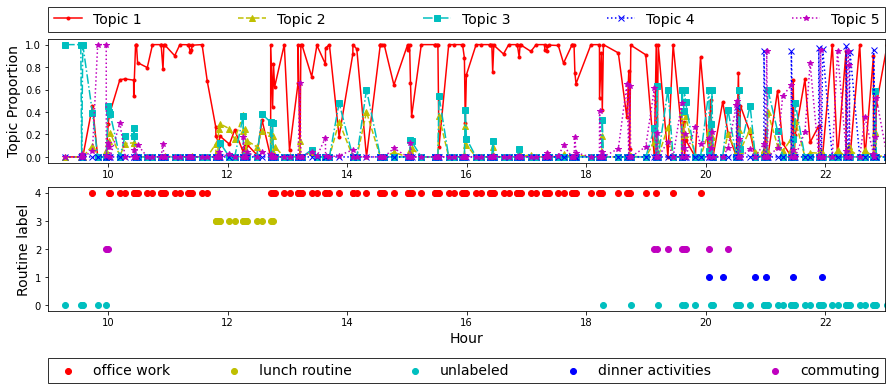

In [430]:
fig, ax = plt.subplots( 2, figsize=(15,5) )
topic_act_top = (-np.sum(distr_act, axis=0)).argsort()[:5]

topic_act_top_reorder = []
list_time = list( chain.from_iterable(time_interval) )
time_reorder = []
for i in range(5):
    lists = sorted(zip(*[ list_time , np.array(distr_act).T[ topic_act_top[i] ]]  ))
    time_reorder, topic_act_top_new = list(zip(*lists))
    topic_act_top_reorder.append( topic_act_top_new )

ax[0].set_xlim([9, 23])
ax[0].plot( time_reorder , topic_act_top_reorder[0], 'r.-' , label="Topic {}".format(1) )
ax[0].plot( time_reorder , topic_act_top_reorder[3], 'y^--', label="Topic {}".format(2) )
ax[0].plot( time_reorder , topic_act_top_reorder[2], 'cs-.', label="Topic {}".format(3) )
ax[0].plot( time_reorder , topic_act_top_reorder[4], 'bx:', label="Topic {}".format(4) )
ax[0].plot( time_reorder , topic_act_top_reorder[1], 'm*:', label="Topic {}".format(5) )


ax[0].set_ylabel('Topic Proportion', fontsize=14)

s = fig.subplotpars
bb=[s.left, s.top+0.02, s.right-s.left, 5 ]
ax[0].legend( loc= 8,bbox_to_anchor=bb, mode="expand", borderaxespad=0, ncol= 5,
                bbox_transform=fig.transFigure, fancybox=False, edgecolor="k", prop={'size':14})


ax[1].set_xlim([9, 23])
color_dict = {4:'r', 3:'y', 0:'c', 1:'b', 2:'m'}
colors = [ color_dict[int(i)]  for i in range(5)]

time_plot = [ [] for _ in range(5) ]
for time_int, routines_dom in zip( list( chain.from_iterable(time_interval) ), routines_dominated  ):
    time_plot[ int(routines_dom) ].append( time_int )
    
for i in color_dict:
    ax[1].scatter( time_plot[i], [i for _ in range(len(time_plot[i]))], c = colors[i], label = routines_label[i]  )
s = fig.subplotpars
bb=[s.left, s.bottom -0.2 , s.right-s.left, 5 ]
ax[1].legend(loc= 8,bbox_to_anchor=bb, mode="expand", borderaxespad=0, ncol= 5,
                bbox_transform=fig.transFigure, fancybox=False, edgecolor="k", prop={'size':14})
ax[1].set_xlabel('Hour', fontsize=14)
ax[1].set_ylabel('Routine label', fontsize=14)

plt.show()

In [431]:
TP = 0
TN = 0
FP = 0
FN = 0
for i, item in enumerate( routines_dominanting ):
    for j in range(i+1):
        if( item !=0 and routines_dominanting[j] !=0 ):
            pair_ground_truth = (item == routines_dominanting[j])
            pair_discovered = (clustering_act_label[i] == clustering_act_label[j])
            if ( pair_ground_truth == True and pair_discovered == True ):
                TP += 1
            elif ( pair_ground_truth == False and pair_discovered == False ):
                TN += 1
            elif ( pair_ground_truth == False and pair_discovered == True ):   
                FP += 1
            else:
                FN += 1
Rand_index = (TP+TN)/(TP+TN+FP+FN)
F_measure = 2*TP/( 2*TP+FP+FN )
print( "Rand index:", Rand_index)
print( "F measure:", F_measure)

Rand index: 0.5051708854525756
F measure: 0.5622930824185398
